In [1]:
from metro_utils import graph, Station, extract_stations, pairs2rails, subsets, total_distance
from collections import defaultdict as dd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=MED)    # fontsize of the axes title
plt.rc('axes', labelsize=MED)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=LARGE)       # controls default text sizes

In [2]:
# Stations
N = 15

Station.reset()
stations = Station.gen_stations(N)

# Stage 0
TSP

$$\begin{aligned}
&z=\min \sum_{i=1}^{n} \sum_{j=1}^{n} c_{i j} x_{i j} \\
&\text { s.t. } \\
&\sum_{j=1}^{n} x_{i j}=1, \quad i \in I, \\
&\sum_{i=1}^{n} x_{i j}=1, \quad j \in I, \\
&\sum_{i \in S}\sum_{j \in S} x_{ij} \leq |S|-1, \qquad S \subset I, 2 \leq |S| \leq n-1, \\
&x_{i j} \in\{0,1\}, \quad i, j=1, \ldots, n.
\end{aligned}$$

In [3]:
subs = subsets(stations)

dist = {(s1, s2): Station.distance(s1, s2) for s1 in stations for s2 in stations}

In [4]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()

x = m.addVars(N, N, vtype=GRB.INTEGER, name="x")

m.setObjective( gp.quicksum( dist[(s1, s2)]*x[s1.id, s2.id] for s1 in stations for s2 in stations if s1 != s2), GRB.MINIMIZE )

# leave each station only once
m.addConstrs( gp.quicksum(x[s1.id, s2.id] for s1 in stations if s1 != s2 ) == 1 for s2 in stations )
# enter each station only once
m.addConstrs( gp.quicksum(x[s1.id, s2.id] for s2 in stations if s1 != s2 ) == 1 for s1 in stations )
# Subtour elimination constraints
for sub in subs:
    m.addConstr( gp.quicksum(x[s1.id, s2.id] for s1 in sub for s2 in sub if s1 != s2) <= len(sub) - 1 )

m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-18
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 16398 rows, 225 columns and 500220 nonzeros
Model fingerprint: 0x0e54f5e6
Variable types: 0 continuous, 225 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 8.8115482
Presolve removed 0 rows and 15 columns
Presolve time: 0.57s
Presolved: 16398 rows, 210 columns, 500220 nonzeros
Variable types: 0 continuous, 210 integer (210 binary)

Root relaxation: objective 4.042635e+00, 43 iterations, 0.24 seconds (0.26 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0    

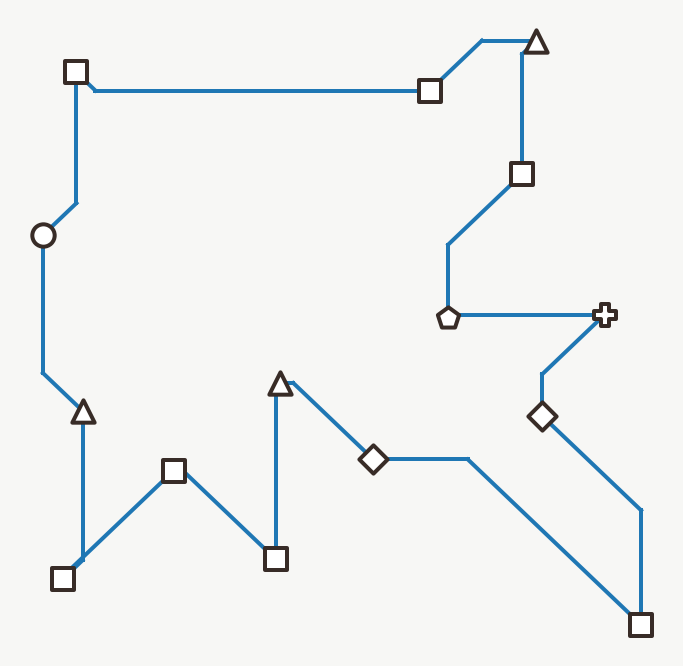

In [5]:
best = pairs2rails([extract_stations(v.varName) for v in m.getVars() if v.x > 1e-6])
graph(stations, best)

# Stage 1
Multi-Depot Multiple Traveling Salesman MmTSP

$$\begin{aligned}
&z=\min \sum_{i=1}^{n} \sum_{j=1}^{n} c_{i j} x_{i j} y_{ij}\\
&\text { s.t. } \\
&\sum_{j=1}^{n} x_{i j} y_{ij}=1, \quad i \in I \\
&\sum_{i=1}^{n} x_{i j} y_{ij}=1, \quad j \in I \\
&2(y_{ij} + 1) = \sum_{k=1}^n x_{ki} + \sum_{k=1}^n x_{jk} , \quad i \in I, j \in J\\
&\sum_{i=1}^n\sum_{j=1}^n y_{ij} \leq m, \quad j \in J\\
&x_{i j} \in\{0,1\}, \quad i, j=1, \ldots, n.
\end{aligned}$$



In [45]:
import gurobipy as gp
from gurobipy import GRB

M = 2
D = [s.id for s in stations[:M]]
V = [s.id for s in stations[M:]]
K = 3
L = N - (M-1)*K
mk = 1 # Num trains from kth depot

c = {(station1.id, station2.id): Station.distance(station1, station2) for station1 in stations for station2 in stations}

m = gp.Model()

x = m.addVars(N, N, M, vtype=GRB.INTEGER, name="x")
u = m.addVars(N, vtype=GRB.INTEGER, name="u")

m.setObjective(gp.quicksum(c[(k, j)]*x[k, j, k] + c[(j, k)]*x[j, k, k] for k in D for j in V) +
               gp.quicksum(c[(i, j)]*x[i, j, k] for k in D for j in V for i in V), GRB.MINIMIZE)

# 2
m.addConstrs(gp.quicksum(x[k, j, k] for j in V) == mk for k in D)
# 3
m.addConstrs(gp.quicksum(x[k, j, k] for k in D) + gp.quicksum(x[i, j, k] for k in D for i in V) == 1 for j in V)
# 4
m.addConstrs(x[k, j, k] + gp.quicksum(x[i, j, k] for i in V) - x[j, k, k] - 
             gp.quicksum(x[j, i, k] for i in V) == 0 for k in D for j in V)
# 5
m.addConstrs(gp.quicksum(x[k, j, k] for j in V) - gp.quicksum(x[j, k, k] for j in V) == 0 for k in D)
# 6
m.addConstrs(u[i] + (L - 2)*gp.quicksum(x[k, i, k] for k in D) - 
             gp.quicksum(x[i, k, k] for k in D) <= L - 1 for i in V)
# 7
m.addConstrs(u[i] + gp.quicksum(x[k, i, k] for k in D) + (2 - K)*gp.quicksum(x[i, k, k] for k in D) >= 2 for i in V)
# 8
m.addConstrs(gp.quicksum(x[k, i, k] for k in D) + gp.quicksum(x[i, k, k] for k in D) <= 1 for i in V)
# 9
m.addConstrs(u[i] - u[j] + L*gp.quicksum(x[i, j, k] for k in D) + 
             (L - 2)*gp.quicksum(x[j, i, k] for k in D) <= L - 1 for i in V for j in V if i != j)
# 10
m.addConstrs(x[i, i, k] == 0 for i in V for k in D)

m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 264 rows, 465 columns and 2262 nonzeros
Model fingerprint: 0x06035303
Variable types: 0 continuous, 465 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [2e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 8.5586926
Presolve removed 26 rows and 88 columns
Presolve time: 0.02s
Presolved: 238 rows, 377 columns, 2184 nonzeros
Variable types: 0 continuous, 377 integer (364 binary)

Root relaxation: objective 4.155358e+00, 110 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    4.15536    0   30    8.55869    4.15536  51.4%     -    0s
H    0     0                       5.1

In [46]:
for var in m.getVars():
    if var.x > 1e-6:
        print(var.varName, var.x)

x[0,12,0] 1.0
x[1,13,1] 1.0
x[2,5,1] 1.0
x[3,8,0] 1.0
x[4,2,1] 1.0
x[5,7,1] 1.0
x[6,9,1] 1.0
x[7,1,1] 1.0
x[8,0,0] 1.0
x[9,14,1] 1.0
x[10,11,1] 1.0
x[11,6,1] 1.0
x[12,3,0] 1.0
x[13,10,1] 1.0
x[14,4,1] 1.0
u[2] 8.0
u[3] 2.0
u[4] 7.0
u[5] 9.0
u[6] 4.0
u[7] 10.0
u[8] 3.0
u[9] 5.0
u[10] 2.0
u[11] 3.0
u[12] 1.0
u[13] 1.0
u[14] 6.0


In [47]:
RAIL = 2

connections = [extract_stations(v.varName) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'x']

rail_pairs = dd(list)
for connection in connections:
    rail_pairs[connection[RAIL]].append(connection[:2])
    
rail_pairs

defaultdict(list,
            {0: [[0, 12], [3, 8], [8, 0], [12, 3]],
             1: [[1, 13],
              [2, 5],
              [4, 2],
              [5, 7],
              [6, 9],
              [7, 1],
              [9, 14],
              [10, 11],
              [11, 6],
              [13, 10],
              [14, 4]]})

In [48]:
rails = []

for rail, pairs in rail_pairs.items():
    rails.append(pairs2rails(pairs))
    
rails

[[0, 12, 3, 8, 0], [1, 13, 10, 11, 6, 9, 14, 4, 2, 5, 7, 1]]

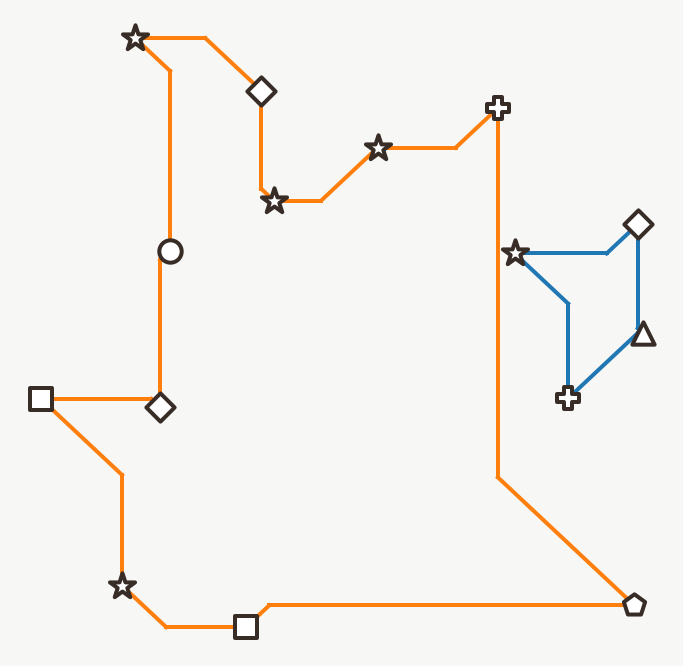

In [49]:
graph(stations, rails)